Authors: Michael Amberg, Wali Chaudhary, Bryce Shurts

# Note: This project was coded in python & transferred to a IPYNB for final submission as an HTML file.

RUBRIC

[2 Points] Present an overview for what type of bias you will be investigating and why the particular investigation you will be doing is relevant. You might consider asking questions like: Why is it important to find this kind of bias in machine learning models? Why will the type of investigation I am performing be relevant to other researchers or practitioners? 

[2 Points] Present one or more research questions that you will be answering and explain the methods that you will employ to answer these research questions. Present a hypothesis as part of your research questions. 

[2 Points] As part of your assignment, you will choose a methodology that involves comparing two (or more) techniques to one another. Discuss how you will measure a difference between the two techniques. That is, if you are measuring the difference statistically, what test will you use and why is it appropriate? Are there any limitations to performing this test that you should be aware of? 

[4 Points] Carryout your analysis and model training. Explain your steps in as much detail so that the instructor can understand your code. 

[4 Points] Present results from your analysis and provide evidence from the results that support or refute your hypothesis. Write a conclusion based upon the various analyses you performed. Be sure to reference your research questions systematically in your conclusion. With your analysis complete, are there any additional research questions or limitations to your conclusions?

[1 Points] Identify two conferences or journals that would be interested in the results of your analysis.  
If using code from another author (not your own), you will be graded on the clarity of explanatory comments you add to the code. 


# Analysis overview
While much of the lab and lessons focus on types of semantic bias embedded into vectors (racial, gender, etc.), we seek to evaluate a more definitionally-focused bias. That is, we seek to investigate the sense bias of the single-sense word embeddings Glove & Numberbatch, and evaluate their ability to avoid biasing toward certain definitions of a set of given words.
Our inspiration for this comes from reasoning agents, such as logic tensor networks (LTNs), that might rely upon semantic vectors for sub-symbolic reasoning and extrapolation of information outside the knowledge of its knowledge base. Consider the following sentence: “I really enjoyed that club today.” Is the subject talking about a golf club, a club sandwich, or an organization? Using our reasoning abilities as human beings, we can infer from the sentence structure that the usage of “club” probably refers to an object like a sandwich or a golf club, rather than an organizational body (in which case, “the club meeting”, “enjoyed trying out that club”, etc. would be a more common phrasing), but an AI does not have this ability: it must rely on the embeddings it has been given.
In a perfectly unbiased system, i.e., one that has the vector of “club” perfectly equidistance in all components for all possible disambiguations of the word, we would not expect the agent/system to infer a bias towards one definition or another, and for there to be a good chance that it determines an accurate conclusion when processing the sentence against some given query (e.g., “Was the club tasty?”). In a biased case, however, the network may have difficult resolving the information on how the word is represented versus what the word meant in proper context: in the worst case it will only have information from a single one of the possible definitions, which would cause the reasonability score of a query to drop even more sharply than in the merely biased case. Therefore, we believe it important to evaluate this kind of bias for the benefit of researchers attempting to utilize pre-trained word embeddings to add additional information to their networks where systemic definitional bias in a single-sense embedding could impair performance.


# Research questions & hypothesis
Before we begin any research and experimentation at all, we must first define what we are trying to figure out, the questions that define this, and provide an expectation that we will be seeing to find evidence in support or refutation of. Put simply, we wish to evaluate whether or not the semantic de-biasing that Numberbatch is well-known for has extended into its performance w.r.t word senses and its ability to evenly represent multiple word senses within a single vector. More specifically, we ask the following:
1.	Has Numberbatch’s efforts to improve upon previous word embedding performance (multi-lingual, semantic debiasing, etc.) improved its ability to provide well-centered definitions for ambiguous words?
2.	If Numberbatch does have an improved ability to equally represent multiple senses, in what cases is this? Is it universally better, or is it only better when specific measures are applied (e.g., is only the cosine similarity metric improved considerably? Is it better in all respects to the Minkowski distance regardless of p value? Is it always worse than some other word embedding?)
These questions, then, inform on the reasonability and accuracy of our hypothesis: Due to Numberbatch’s multi-lingual nature and debiasing efforts, we believe that it will exhibit superior performance vis-à-vis having semantic vectors that are near-equidistant to disambiguated definitional senses.


# Measurement strategy
To answer these questions and attempt to find an answer for our hypothesis, we consider two separate metrics: the distance between vectors, and how similar any 2 given vectors are. For measuring distance, we use the Minkowski distance formula with 2 sperate p values, p=1 (the Manhattan distance) & p=2 (the Euclidian distance). We believe that the Manhattan distance will provide better results given the high dimensionality space the embeddings operate in, but we will also include the Euclidian distance for completion’s sake and for cross-comparison against the Manhattan distance findings. For comparison vector similarity, we instead turn to the cosine similarity formula, so that we might evaluate how similar any two words, or datapoints, are to each other.
Within any given measurement method, we will compare each of our 2 embeddings, utilizing a set of words that we have hand-picked for their ambiguity, alongside disambiguating synonyms for the potential definitions. From there, the process is as such:
1.	Example words: light (ambiguous word), illumination (disambiguated definition), & lightweight (disambiguated definition)
2.	Take the Manhattan distance, Euclidian distance, and Cosine similarity of light & illumination, as well as light & lightweight
3.	Compute the ratio of the distance by dividing the larger number by the smaller number
4.	Repeat this process for the other word embedding
5.	Repeat for all sets of words provided (25 total)
6.	Boxplot these ratios on a per-metric basis
This will allow us to compare several kinds of potential metrics to mitigate potential biases that may result from the representation of distance and/or similarity in just one metric (the Euclidian distance, for instance, may overly equalize the high dimensionality data). By having 3 metrics, we provide the opportunity for there to be a quorum: we expect that in the case of one set of word embeddings performing better than the others w.r.t how well-balanced the ambiguous words are represented, then we should see it outperform the other word embeddings in at least 2 of the 3 metrics.


In [6]:
import math
import os
from types import FunctionType

import pandas as pd
import torch
import torchtext
from gensim.models import KeyedVectors

# BASE_PATH: str = os.path.dirname(os.path.abspath(__file__))
BASE_PATH: str = "" # REPLACE THIS LINE FOR YOUR LOCAL

CLASSIFIERS_PATH: str = BASE_PATH + "classifiers/"
DATASET_PATH: str = BASE_PATH + "datasets/"
EMBEDDINGS_PATH: str = BASE_PATH + "embeddings/"
NUM_EMOTIONS: int = 28
EMBED_SIZE: int = 0

# Check if our key directories exist
if not os.path.exists(CLASSIFIERS_PATH):
    raise FileNotFoundError("Could not find folder for classifier models.")
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError("Could not find folder with GoEmotion dataset.")
if not os.path.exists(EMBEDDINGS_PATH):
    raise FileNotFoundError("Could not find folder with word embeddings sets.")

# Is the cuda GPU available?
if not torch.cuda.is_available():
    print("Warning: Using CPU for Pytorch.")
device: device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
class pandas_dataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, index: int) -> (str, str):
        return self.df["text"].iloc[index], self.df["emotion_ids"].iloc[index]

In [8]:
def parse_word2vec(word2vec_embeddings, embedding_components) -> tuple[dict[str, int], torch.Tensor]:
        word_labels: dict[str, int] = {}
        tensor: torch.Tensor = torch.empty((EMBED_SIZE + 1, embedding_components), dtype=torch.float32, device=device)
        
        # Clean up the file and load the embeddings into a tensor
        loop_idx = 0
        for word, idx in word2vec_embeddings.key_to_index.items():
            word_labels[word] = idx
            tensor[idx] = torch.tensor(word2vec_embeddings.get_vector(word), dtype=torch.float32,
                                         device=device)
            # Output our progress every 100,000 words
            if (loop_idx + 1) % 100000 == 0:
                print("Processed {}/{}".format(loop_idx + 1, EMBED_SIZE))
            loop_idx += 1
        tensor[-1] = torch.zeros(embedding_components, dtype=torch.float32, device=device)

        # Adding a padding token
        word_labels["<PAD>"] = EMBED_SIZE
        tensor.to(device)
        return word_labels, tensor

"""Deserialize the embeddings, and return word labels with their corresponding tensors."""
def get_vectors(embedding: str) -> tuple[dict[str, int], torch.Tensor]:
    skip_first_line: bool = False
    global EMBED_SIZE
    match embedding:
        case "glove":
            embedding_path: str = EMBEDDINGS_PATH + "glove.840B.300d.txt"
            EMBED_SIZE = 2196018
            embedding_components: int = 300
        case "word2vec":
            embedding_path: str = EMBEDDINGS_PATH + "GoogleNews-vectors-negative300.bin"
            gn_model = KeyedVectors.load_word2vec_format(embedding_path, binary=True)
            embedding_components: int = 300
            EMBED_SIZE = 3000000
            return parse_word2vec(gn_model, embedding_components)
        case "numberbatch":
            embedding_path: str = EMBEDDINGS_PATH + "numberbatch-19.08-en.txt"
            EMBED_SIZE = 516782
            embedding_components: int = 300
            skip_first_line = True
        case default:
            raise RuntimeError("Invalid embedding chosen.")
        
    # Deserializing glove and numberbatch embeddings
    if not os.path.exists(embedding_path):
        raise FileNotFoundError("Could not find embedding file: {}".format(embedding_path))
    with (open(embedding_path, encoding="utf_8") as embeddings_file):
        word_labels: dict[str, int] = {}
        tensor: torch.Tensor = torch.empty((EMBED_SIZE + 1, embedding_components), dtype=torch.float32, device=device)
        
        # We need to skip the first line of the numberbatch embeddings because that's header information
        if skip_first_line:
            _ = embeddings_file.readline()
        
        # Clean up the file and load the embeddings into a tensor
        for index, embedding in enumerate(embeddings_file):
            embedding_split: list[str] = embedding.rstrip().split(" ")
            word_labels[embedding_split[0]] = index # Assign the word to the index
            tensor[index] = torch.tensor([float(val) for val in embedding_split[1:]], dtype=torch.float32, # Every element except the first is converted to a float
                                         device=device)
            # Output our progress every 100,000 words
            if (index + 1) % 100000 == 0:
                print("Processed {}/{}".format(index + 1, EMBED_SIZE))
        tensor[-1] = torch.zeros(embedding_components, dtype=torch.float32, device=device)

        # Adding a padding token
        word_labels["<PAD>"] = EMBED_SIZE
        tensor.to(device)
        return word_labels, tensor

In [9]:
# Download link for word2vec: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing
# Download link for Glove: https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip

import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
from sklearn.manifold import TSNE
from torch import Tensor, cat
from torch.cuda import is_available as cuda_is_available
from train import get_vectors


# EDITABLE VARIABLES
embeddings = ["numberbatch", "glove"] # Embeddings definition. Add word2vec once deserialization is done.

# Word comparison groups. Format: [base_word, similar_word_1, similar_word_2]
word_comparison_groups = [
    ["tire", "tired", "tyre"],
    ["chest", "thorax", "crate"],
    ["fall", "autumn", "plummet"],
    ["bear", "carry", "ursidae"],
    ["proof", "evidence", "testing"],
    ["tear", "rip", "droplet"],
    ["salty", "flavored", "tough"],
    ["land", "earth", "arrive"],
    ["close", "near", "shut"],
    ["light", "illumination", "lightweight"],
    ["match", "competition", "firestarter"],
    ["wind", "breeze", "coil"],
    ["fly", "diptera", "flight"],
    ["lead", "guide", "pb"],
    ["watch", "observe", "wristwatch"],
    ["file", "organize", "rasp"],
    ["change", "modify", "currency"],
    ["bark", "woof", "skin"],
    ["refuse", "decline", "garbage"],
    ["protest", "rally", "complain"],
    ["escort", "companion", "accompany"],
    ["produce", "food", "make"],
    ["desert", "abandon", "wilderness"],
    ["live", "stream", "exist"],
    ["house", "home", "contain"]
]

# Add a new distance function here if you want.
"""Calculate the distances between a base word and two similar words using Euclidean, Cosine, and Manhattan distances."""
def calculate_distances(base_word: ndarray[float], similar_word_1: ndarray[float], similar_word_2: ndarray[float]) -> dict[str, list[float]]:
    return {
        "euclidean": [euclidean_distance(similar_word_1, base_word), euclidean_distance(similar_word_2, base_word)],
        "cosine": [cosine_similarity(similar_word_1, base_word), cosine_similarity(similar_word_2, base_word)],
        "manhattan": [manhattan_distance(similar_word_1, base_word), manhattan_distance(similar_word_2, base_word)],
    }

# We should look at comparing vectors in different embeddings and see how well ambigious words center around common
# synonyms for each meaning. We could probably do some sort of visualization for this as well.

def euclidean_distance(vector1: Tensor, vector2: Tensor) -> float:
    return np.linalg.norm(vector1 - vector2)

def cosine_similarity(vector1: Tensor, vector2: Tensor) -> float:
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

def manhattan_distance(v1, v2):
    return np.sum(np.abs(v1 - v2))

In [10]:
"""Converts the given list of tensors to a numpy array based on GPU availability."""
def convert_tensors_to_numpy(embeddings_list: list[Tensor]) -> ndarray[float]:
    if cuda_is_available():
        numpy_vectors = np.array([vector.cpu().numpy() for vector in embeddings_list])
    else:
        numpy_vectors = np.array([vector.numpy() for vector in embeddings_list])
    return numpy_vectors

"""Returns the word vectors to compare from the given numpy vectors. These vectors are a word groups members"""
def get_word_vectors_to_compare(numpy_vectors: ndarray[float]) -> tuple[ndarray[float], ndarray[float], ndarray[float]]:
    return numpy_vectors[0], numpy_vectors[1], numpy_vectors[2]

"""Returns a dictionary of distance types to their calculated distances for the given word vectors."""
def get_distances(embeddings_list: list[Tensor]) -> dict[str, list[float]]:
    numpy_vectors = convert_tensors_to_numpy(embeddings_list)
    base_word, similar_word1, similar_word2 = get_word_vectors_to_compare(numpy_vectors)
    return calculate_distances(base_word, similar_word1, similar_word2)

"""Returns a dictionary of embedding names to their respective word vectors and vocabularies"""
def get_embeddings(embeddings: list[str]) -> dict[str, (dict[str, int], Tensor)]:
    if len(embeddings) == 0:
        raise ValueError("No embeddings were selected to load.")
    
    result = {}
    for embedding in embeddings:
        vocab, vectors = get_vectors(embedding)
        result[embedding] = (vocab, vectors)
    return result

"""Returns a dictionary of embedding names to a list of comparison groups, the words whose distances are being compared"""
def get_comparison_embeddings(embeddings: dict[str, (dict[str, int], Tensor)]) -> dict[str, list[list[Tensor]]]:
    # Dictionary of embedding name to list of comparison groups
    result: dict[str, list[list[Tensor]]] = {}
    for embed_name, (vocab, vectors) in embeddings.items():
        comparisons = []
        if embed_name not in result:
            result[embed_name] = []
        
        # Populate the comparison groups
        for idx, group in enumerate(word_comparison_groups):
            comparisons = []
            for word in group:
                comparisons.append(vectors[vocab[word]])
            result[embed_name].append(comparisons)
    return result

"""Returns a dictionary of embedding names to a list of dictionaries of distance types to their calculated distances"""
def compare_embeddings(comparison_embeddings: dict[str, list[list[Tensor]]]) -> dict[str, list[dict[str, list[float]]]]:
    result = {}
    for embedding, word_groups in comparison_embeddings.items():
        for idx, group_vectors in enumerate(word_groups):
            if result.get(embedding) is None:
                result[embedding] = []
            distances: dict[str, list[float]] = get_distances(group_vectors)
            result[embedding].append(distances)
    return result

In [11]:

"""Plots boxplots of the distance ratios for each embedding and distance type."""
def compare_distances(embedding_distances: dict[str, list[dict[str, list[float]]]]):
    """Returns a dictionary of embedding names to a dictionary of distance types to their calculated distance ratios."""
    def calculate_distance_ratios():
        # Dict of embedding name to distance type and all of that distance type's calculated distance ratios
        ratios: dict[str, dict[str, list[float]]] = {}
        # For every distance type for embeddings
        for embedding_name, distances in embedding_distances.items():
            ratios[embedding_name] = {}
            for distance in distances:
                for distance_type, values in distance.items():
                    if ratios[embedding_name].get(distance_type) is None:
                        ratios[embedding_name][distance_type] = []
                    ratio = (max(values[0], values[1]) / min(values[0], values[1]))
                    ratios[embedding_name][distance_type].append(ratio)
        return ratios

    """
    Plots boxplots of the distance ratios for each embedding and distance type.
    Args: ratios: dict[str, dict[str, list[float]]] - Dictionary of embedding names to a dictionary of distance types to a list of all their calculated distance ratios.
    
    Ex:
    ratios = {
        "glove": {
            "euclidean": [1.0, 2.55, 1.380, 4.44, 4.4, 4983],
            "cosine": [1.0, 2.55, 1.380, 4.44, 4.4, 4983],
            ...
        },
        "numberbatch": {
            "euclidean": [1.0, 2.55, 1.380, 4.44, 4.4, 4983],
            "cosine": [1.0, 2.55, 1.380, 4.44, 4.4, 4983],
            ...        
        }
    }
    """
    def show_boxplots(ratios: dict[str, dict[str, list[float]]]):
        distances: list[dict[str, list[float]]] = list(ratios.values())
        # Get all the values per distance type for every embedding
        to_plot = {}
        for i in range(0, len(distances)):
            for embedding_name, distances2 in ratios.items():
                for distance_type, values in distances2.items():
                    print(embedding_name, distance_type, values)
                    if to_plot.get(distance_type) is None:
                        to_plot[distance_type] = {}
                    to_plot[distance_type][embedding_name] = values
        
        # For every distance metric, plot boxplots for all embeddings
        for distance_type, embedding_data in to_plot.items():
            fig, axs = plt.subplots(figsize=(10, 8))
            boxplots_data = []
            labels = []
            for embedding_name, values in embedding_data.items():
                boxplots_data.append(values)
                labels.append(embedding_name)
            axs.boxplot(boxplots_data)
            axs.set_xticklabels(labels)
            axs.set_title(distance_type)
            plt.tight_layout()
            plt.show()
    
    # Dict of embedding name to distance type and its calculated distance ratio
    ratios = calculate_distance_ratios()
    show_boxplots(ratios)

Processed 100000/516782
Processed 200000/516782
Processed 300000/516782
Processed 400000/516782
Processed 500000/516782
Processed 100000/2196018
Processed 200000/2196018
Processed 300000/2196018
Processed 400000/2196018
Processed 500000/2196018
Processed 600000/2196018
Processed 700000/2196018
Processed 800000/2196018
Processed 900000/2196018
Processed 1000000/2196018
Processed 1100000/2196018
Processed 1200000/2196018
Processed 1300000/2196018
Processed 1400000/2196018
Processed 1500000/2196018
Processed 1600000/2196018
Processed 1700000/2196018
Processed 1800000/2196018
Processed 1900000/2196018
Processed 2000000/2196018
Processed 2100000/2196018
numberbatch euclidean [2.0228667, 1.3917134, 1.0818952, 1.6763003, 1.7939473, 1.5877889, 1.2180035, 1.290396, 1.0466881, 1.7501041, 1.146394, 1.6071962, 1.0081002, 1.1423978, 1.0892727, 1.0956494, 1.5042249, 1.2922068, 1.0811625, 1.0834851, 1.100152, 1.2863295, 1.3524644, 1.1069232, 1.6510735]
numberbatch cosine [2.6500287, 2.0938087, 1.1085

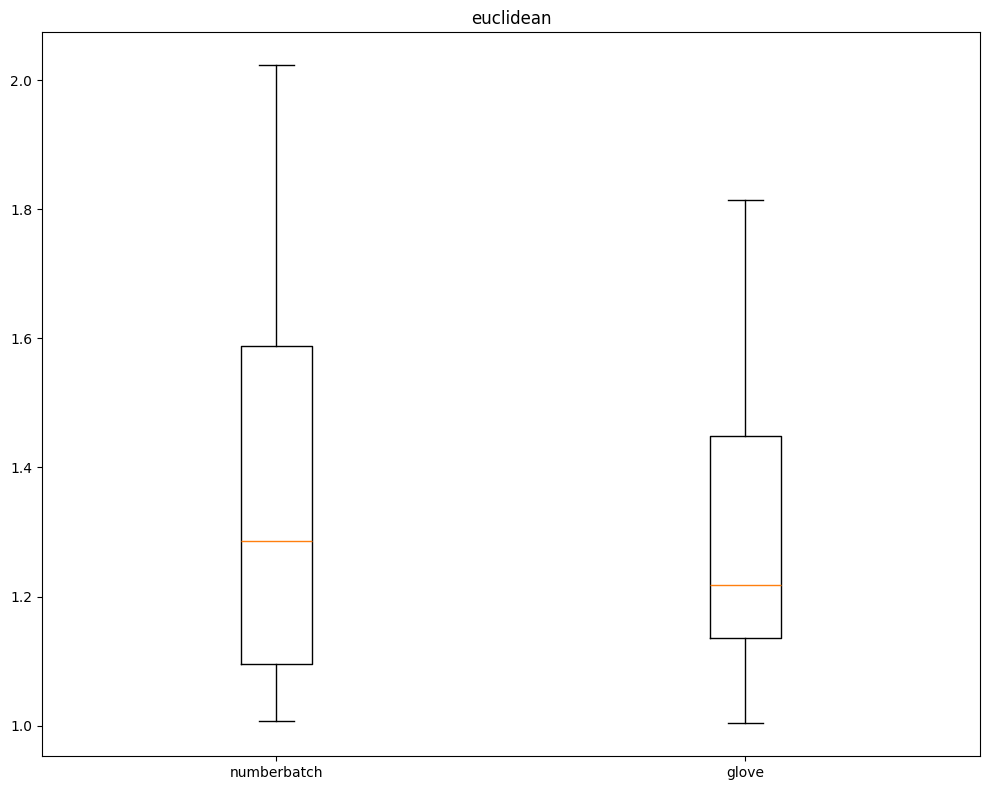

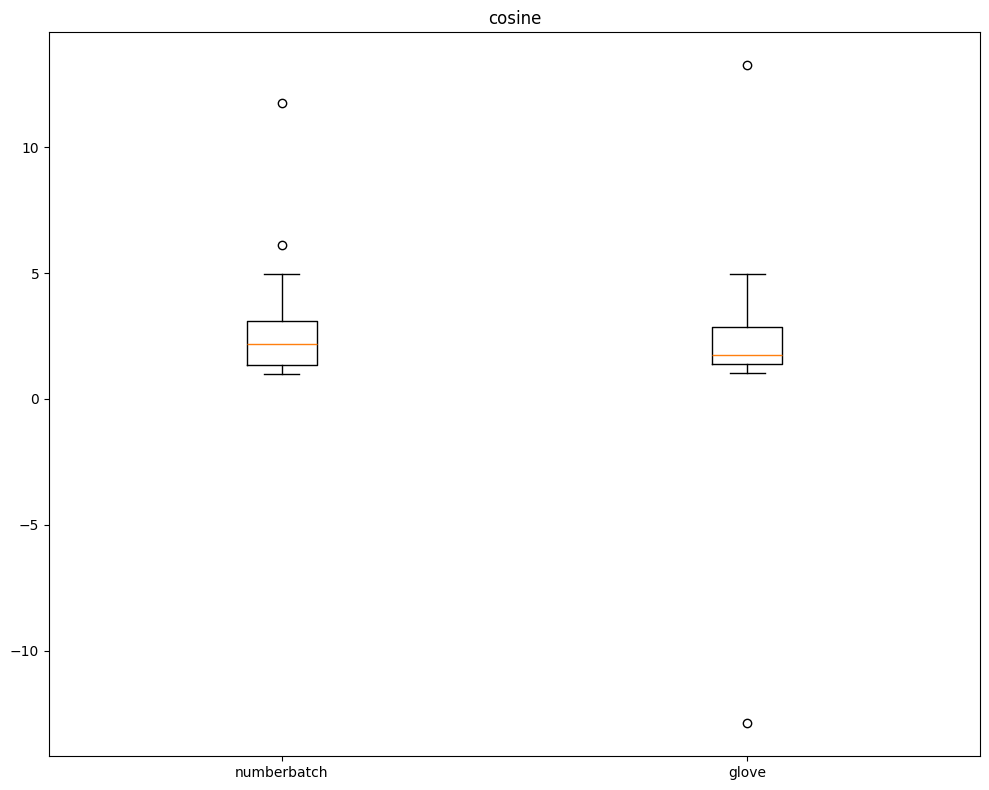

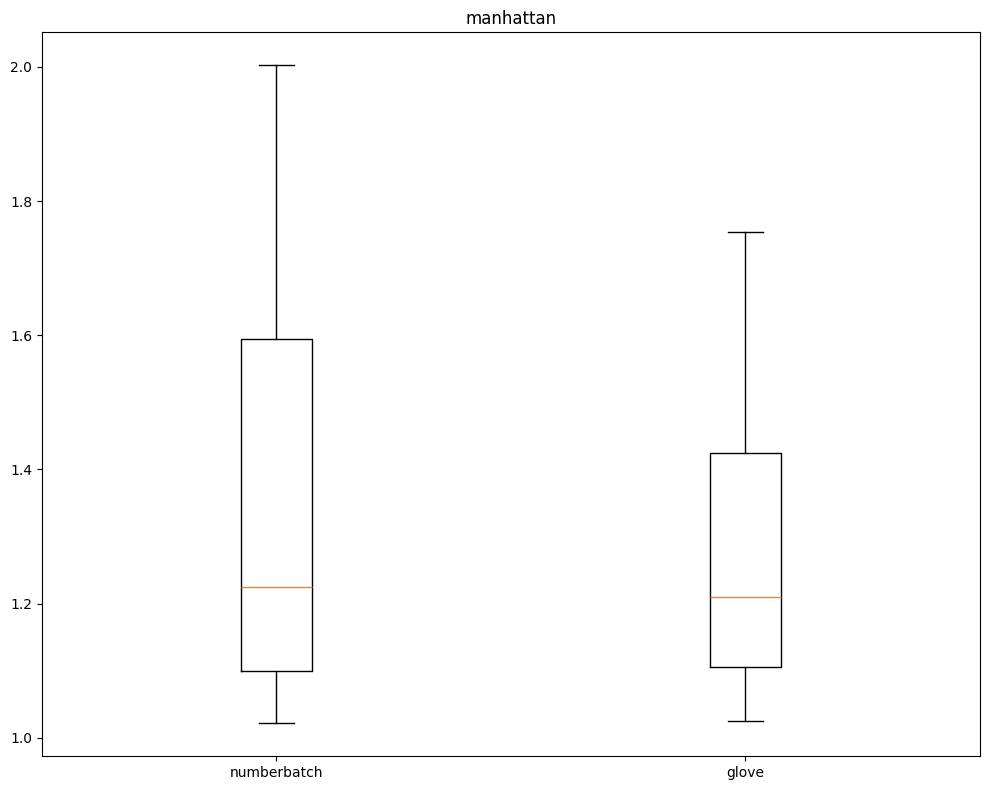

In [12]:
orig_embeddings = get_embeddings(embeddings)
comp_embeddings = get_comparison_embeddings(orig_embeddings)
comp_distances = compare_embeddings(comp_embeddings)
compare_distances(comp_distances)

# Analysis findings
As we can see, the figures show a result that almost seems too close to call. In all cases, Glove & Numberbatch have distance ratios within about ~0.1, with the cosine similarity having a wider margin, with a median difference of about a full point between Numberbatch & Glove.
While these margins may certainly seem slim, the consistency of the results does present a tendency towards an answer to our original research questions. Rather than seeing an improved performance from Numberbatch in relation to how well it averages ambiguous word definitions, it instead performance consistently worse, tending to have a worse bias towards one definition over another in the average cases across all tested metrics. This does not necessarily indicate an absolute performance metric being appreciatively worse, but the IQR being significantly smaller in all 3 metrics does indicate that there may be an overall tendency for Numberbatch to center on singular definitions of words (or at least some subset of definitions) over evenly representing all ambiguous word senses within a given embedding.
As such, we can confidently reject our hypothesis: Numberbatch’s efforts to debias & its multi-lingual capabilities have not represented in any improved performance in relation to the embeddings’ ability to evenly represent word definitions. Rather, Numberbatch’s performance is consistently worse across all measured metrics, with its IQRs and median tending to result in a larger ratio (worse) on average versus Glove’s results. Therefore, we state that our hypothesis was incorrect and Numberbatch does not have superior performance vis-à-vis having semantic vectors that are near-equidistant to disambiguated definitional senses.


# Potential conferences or journals
We believe that the results of our research, if sufficiently beefed up to introduce additional rigor and analysis, may 
be of interests to a conference such as The International Conference on Learning Representations (ICLR), which has already hosted papers on bias mitigation & analysis, as well as The Conference on Fairness, Accountability, and Transparency (FAccT), which has research on the ethical considerations and transparency of AI as one of its focal points. We believe that our work representations a meaningful avenue of research within the considerations of both bias and transparency within Ais, and believe these conferences would be well suited to the publishment of our work.
